# ECE 753 HW1 New York Wholesale Electricity Pricing Analysis

## John Yu

# Source datasets
* NYISO LBMP enclosing the specified time periods
    * dayahead hourly
    * realtime 5-min
* NYISO integrated real-time load enclosing the specified time periods
    * hourly
* NOAA Integrated Surface Data (ISD) enclosing the specified time periods
    * historical **hourly dry-bulb air temperature** 
    * reported by airports and beacons in the vincinity of NYC 

# Data Preparation (1 of 4) -- Archive Retrival

* Developed Python Library
    * Retrieve Internet remote files -- based on `urllib`
    * Unpack compressed archives -- based on `shutil`
    * Parse CSV files -- based on `pandas`

* The library artifacts will be uploaded to the Google Drive as part of the submission.

# Data Preparation (2 of 4) -- Important Issues -- Dataset Timezones

* NYISO LBMP dataset timezone in EST -- localized to EST, then converted to UTC
    * EST doesn't have daylight savings (compared to EDT which does) -- exception is raised

* NYISO integrated realtime load in mixture of EST and EDT -- localized accordingly, then converted to UTC

* NOAA dataset timezone in UTC -- localized to UTC

## On Dec/31/2016, a leap second is applied to UTC at 23:59:60
* Not clear how NYISO and NOAA handles it
* Program is able to handle records that land on leap seconds (mature locale libraries)


1. Import → Timezone-naive DateTimeIndex 
1. Localize → Timezone-aware DateTimeIndex (Local Time)
1. Convert → Timezone-aware DateTimeIndex (UTC Time)


![](images/nyiso-dataframe.png)

![](images/nyiso-load-timezone.png)

# Data Preparation (2 of 4) -- Important issues -- Missing records

* Filling NA by locational redundancy (averaging)
    * NOAA ISD averages weather stations around NYC


* Filling NA by temporal redundancy (forward fill)
    * NOAA ISD after averaging
    * NYISO Dayahead LBMP
    * NYISO Realtime LBMP
    * NYISO Integrated Load

# Data Preparation (2 of 4) -- Important issues -- Timestamp alignment

* Target timestamp -- strict 1-hour boundaries

* Timestamps in 1-hour boundaries
    * NYISO dayahead LBMP
    * NYISO integrated load
    * Resample and average into previous full hour, just in case

* Timestamps in 5-min boundaries
    * NYISO realtime LBMP
    * Resample and average into previous full hour
 
* NOAA ISD global hourly -- scattered timestamp
    * Resample and average into previous full hour

In [1]:
%load_ext autoreload
%autoreload
import logging

import numpy
import pandas

from matplotlib import (
    pyplot,
)

from glob import (
    glob,
)

import modules.nyc.pricing        as nyc_pricing
import modules.nyc.load           as nyc_load
import modules.noaa.global_hourly as noaa_hourly

# Data Preparation (3 of 4) -- Data import for NYISO

In [2]:
months_to_download = {
    # year: [list_of_months]
    '2016': ['11', '12'],
    '2017': ['01', '02', '03', '04', '11', '12'],
    '2018': ['01', '02', '03', '04', '11', '12'],
    '2019': ['01', '02', '03', '04', '11', '12'],
    '2020': ['01', '02', '03', '04', '11', '12'],
    '2021': ['01', '02', '03', '04'],
}

In [3]:
# archive handling objects
dayahead_lbmp_archives = [
    nyc_pricing.Dayahead_LBMP_Remote_Archive(m, y)

    for y, months in months_to_download.items()
    for m in months
]

realtime_lbmp_archives = [
    nyc_pricing.Realtime_LBMP_Remote_Archive(m, y)

    for y, months in months_to_download.items()
    for m in months
]

realtime_load_archives = [
    nyc_load.Integrated_Real_Time_Load_Remote_Archive(m, y)
    
    for y, months in months_to_download.items()
    for m in months
]

In [4]:
# download everything
for archive in (dayahead_lbmp_archives + 
                realtime_lbmp_archives +
                realtime_load_archives):
    try:
        archive.download_into('999-data/download/')
        
    except Exception as e:
        logging.error('Error downloading {}: {}'.format(archive.url, e))

In [5]:
# unpack everything
for archive in dayahead_lbmp_archives:
    archive.extract_into('999-data/dayahead-lbmp/')

for archive in realtime_lbmp_archives:
    archive.extract_into('999-data/realtime-lbmp/')

for archive in realtime_load_archives:
    archive.extract_into('999-data/realtime-load/')

In [6]:
dayahead_lbmp_csv_files = glob('999-data/dayahead-lbmp/*.csv')
realtime_lbmp_csv_files = glob('999-data/realtime-lbmp/*.csv')
realtime_load_csv_files = glob('999-data/realtime-load/*.csv')

df_dayahead_lbmp = nyc_pricing.read_csv_slices(dayahead_lbmp_csv_files)
df_realtime_lbmp = nyc_pricing.read_csv_slices(realtime_lbmp_csv_files)
df_realtime_load = nyc_load.read_csv_slices(realtime_load_csv_files)

In [7]:
# pivot zone column
def pivot_zones(df, value_columns):
    return df.pivot_table(index=df.index, columns='zone', aggfunc='first', 
                          values=value_columns)

df_dayahead_lbmp = pivot_zones(df_dayahead_lbmp, value_columns='lbmp')
df_realtime_lbmp = pivot_zones(df_realtime_lbmp, value_columns='lbmp')
df_realtime_load = pivot_zones(df_realtime_load, value_columns='integrated_load')

In [8]:
# forward fill NaN Values
df_dayahead_lbmp.fillna(method='ffill', inplace=True)
df_realtime_lbmp.fillna(method='ffill', inplace=True)
df_realtime_load.fillna(method='ffill', inplace=True)

# resample to align all records to previous full hour
df_dayahead_lbmp = df_dayahead_lbmp.resample('1h').mean()
df_realtime_lbmp = df_realtime_lbmp.resample('1h').mean()
df_realtime_load = df_realtime_load.resample('1h').mean()

In [9]:
display(df_dayahead_lbmp)

zone,CAPITL,CENTRL,DUNWOD,GENESE,H Q,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,NPX,O H,PJM,WEST
utc_time,,,,,,,,,,,,,,,
2016-11-01 05:00:00+00:00,20.43,19.49,20.99,19.08,18.79,20.99,21.61,19.87,20.97,21.15,18.83,21.95,15.22,19.97,19.55
2016-11-01 06:00:00+00:00,18.73,17.76,19.22,17.35,17.16,19.24,19.68,18.09,19.24,19.33,17.18,22.12,14.34,18.32,17.88
2016-11-01 07:00:00+00:00,18.29,17.36,18.75,17.10,16.75,18.79,19.35,17.67,18.79,18.84,16.75,21.79,13.21,17.89,17.46
2016-11-01 08:00:00+00:00,17.70,16.78,18.13,16.55,16.20,18.18,18.65,17.07,18.16,18.21,16.20,20.60,13.18,17.30,16.85
2016-11-01 09:00:00+00:00,17.63,16.81,18.06,16.60,16.15,18.09,18.69,17.08,18.08,18.14,16.15,21.01,13.34,17.28,16.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01 00:00:00+00:00,43.39,8.26,31.50,6.97,3.22,31.36,32.61,8.35,31.89,31.55,3.15,36.70,7.58,20.57,8.00
2021-05-01 01:00:00+00:00,43.48,8.97,31.85,7.68,4.00,31.71,33.21,9.10,32.24,31.90,3.91,36.91,8.23,21.07,8.66
2021-05-01 02:00:00+00:00,37.24,8.20,27.62,7.10,4.00,27.46,29.93,8.33,27.93,27.67,3.92,31.42,7.55,18.46,7.93


In [10]:
display(df_realtime_lbmp)

zone,CAPITL,CENTRL,DUNWOD,GENESE,H Q,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,NPX,O H,PJM,WEST
utc_time,,,,,,,,,,,,,,,
2016-11-01 05:00:00+00:00,19.238571,19.126364,21.180000,18.738889,18.697273,21.039091,20.970000,19.178000,20.930000,20.478182,19.251818,20.556364,17.981000,18.560000,18.891818
2016-11-01 06:00:00+00:00,18.345000,15.780833,16.705000,16.052500,15.421667,17.461667,17.720833,15.468333,17.830833,17.608333,16.194167,17.399167,15.830833,15.557500,16.488333
2016-11-01 07:00:00+00:00,17.421667,16.003333,17.082500,15.564167,14.817500,16.929167,17.362500,14.078333,17.215000,17.977500,16.477500,21.664167,15.386667,15.170000,14.822500
2016-11-01 08:00:00+00:00,19.329167,19.049167,21.278333,16.296667,17.201667,21.090000,20.827500,19.450000,19.204167,21.427500,18.050833,22.689167,18.376667,19.775000,18.594167
2016-11-01 09:00:00+00:00,18.844167,13.971667,19.096667,16.919167,18.872500,19.435833,19.500000,16.916667,19.320000,20.954167,17.279167,19.209167,15.417500,18.262500,16.749167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01 01:00:00+00:00,24.072500,9.042500,19.327500,8.362500,4.230833,19.205833,19.475833,8.837500,19.529167,19.151667,15.330000,21.460833,8.349167,14.177500,8.690833
2021-05-01 02:00:00+00:00,24.419167,12.211667,20.878333,11.719167,9.312500,20.734167,21.052500,12.327500,20.982500,20.935833,11.259167,22.314167,11.379167,16.686667,11.790000
2021-05-01 03:00:00+00:00,25.704167,6.185000,19.392500,5.729167,8.725833,19.292500,19.513333,6.467500,19.654167,19.455833,4.494167,22.243333,5.974167,13.177500,6.517500


In [11]:
display(df_realtime_load)

zone,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST
utc_time,,,,,,,,,,,
2016-11-01 04:00:00+00:00,NaN,1548.5000,NaN,903.8000,NaN,NaN,NaN,NaN,4552.9000,NaN,NaN
2016-11-01 05:00:00+00:00,1097.0000,1524.6000,NaN,879.4000,NaN,NaN,716.7000,NaN,4327.5000,463.2000,NaN
2016-11-01 06:00:00+00:00,1085.7000,1489.8000,NaN,879.4000,NaN,1606.0000,706.4000,NaN,4203.8000,461.6000,NaN
2016-11-01 07:00:00+00:00,1085.7000,1495.0000,472.4000,863.5000,NaN,1606.0000,714.1000,NaN,4145.2000,461.6000,1431.3000
2016-11-01 08:00:00+00:00,1126.5000,1534.4000,472.4000,863.5000,NaN,1606.0000,714.1000,NaN,4186.6000,461.6000,1431.3000
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30 23:00:00+00:00,1284.7080,1746.4856,599.0945,1091.8391,964.0195,2147.7264,866.7562,288.3569,5082.6904,617.4074,1645.2009
2021-05-01 00:00:00+00:00,1291.3348,1764.5217,604.1910,1107.0151,985.9600,2173.9468,881.0033,291.8085,4994.6882,615.0235,1673.2308
2021-05-01 01:00:00+00:00,1246.0122,1723.9340,586.0588,1067.6122,951.3716,2077.5913,855.1418,277.2349,4851.5086,610.8820,1629.1064


![](images/nyca_zonemaps.svg)

# Data Preparation (4 of 4) -- Data Import for NOAA

Links
* List of NOAA NCEI weather stations https://www.ncei.noaa.gov/pub/data/noaa/isd-history.txt
* Integrated Surface Data (ISD) format documentation (for parsing temperature) https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf

![](images/isd-documentation.png)

In [12]:
download_stations = {
    # noaa_station_id
    '99727299999',
    '74486094789',
    '99728099999',
    '72503014732',
    '72502014734',
    '72505394728',
    '72055399999',
    '99774399999',
    '99728999999',
    '72502594741',
    '99727199999'
}

weather_years = ['2016', '2017', '2018', '2019', '2020', '2021']

In [13]:
noaa_isd_archives = [
    noaa_hourly.ISD_Remote_File(year, station)

    for station in download_stations
    for year in weather_years
]

for archive in noaa_isd_archives:
    try:
        archive.download_into('999-data/noaa')

    except Exception as e:
        logging.error('Error downloading {}: {}'.format(archive.url, e))

ERROR:root:Error downloading https://www.ncei.noaa.gov/data/global-hourly/access/2016/99727299999.csv: HTTP Error 404: Not Found
ERROR:root:Error downloading https://www.ncei.noaa.gov/data/global-hourly/access/2016/99728999999.csv: HTTP Error 404: Not Found
ERROR:root:Error downloading https://www.ncei.noaa.gov/data/global-hourly/access/2016/99727199999.csv: HTTP Error 404: Not Found
ERROR:root:Error downloading https://www.ncei.noaa.gov/data/global-hourly/access/2016/99774399999.csv: HTTP Error 404: Not Found
ERROR:root:Error downloading https://www.ncei.noaa.gov/data/global-hourly/access/2016/99728099999.csv: HTTP Error 404: Not Found


### Celsius string format

![](images/celsius_format.png)

In [14]:
noaa_csv_files = glob('999-data/noaa/*.csv')
df_noaa = noaa_hourly.read_csv_slices(noaa_csv_files)

## Drop low quality celsius readings

![](images/celsius_quality.png)

In [15]:
KEEP_QUALITY = ['0', '1', '4', '5', '9', 'A', 'C', 'I', 'M', 'P', 'R', 'U']
drop_mask = [item not in KEEP_QUALITY for item in df_noaa['celsius_quality']]
df_noaa.drop(df_noaa.index[drop_mask], inplace=True)

In [16]:
# dataset preview after dropping low quality readings
display(df_noaa)

,station,latitude,longitude,elevation,name,celsius,celsius_quality
utc_time,,,,,,,
2016-01-01 00:00:00+00:00,74486094789,40.639150,-73.764010,3.40,"JFK INTERNATIONAL AIRPORT, NY US",8.3,1
2016-01-01 00:00:00+00:00,72502014734,40.682500,-74.169400,2.10,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",7.2,1
2016-01-01 00:00:00+00:00,72503014732,40.779440,-73.880350,3.40,"LAGUARDIA AIRPORT, NY US",7.8,1
2016-01-01 00:15:00+00:00,72058199999,40.617447,-74.244594,7.01,"LINDEN, NJ US",6.4,1
2016-01-01 00:35:00+00:00,72058199999,40.617447,-74.244594,7.01,"LINDEN, NJ US",6.5,1
...,...,...,...,...,...,...,...
2021-12-31 23:51:00+00:00,74486094789,40.639150,-73.763900,2.70,"JFK INTERNATIONAL AIRPORT, NY US",9.4,1
2021-12-31 23:51:00+00:00,72503014732,40.779450,-73.880270,3.00,"LAGUARDIA AIRPORT, NY US",10.6,1
2021-12-31 23:51:00+00:00,72505394728,40.778980,-73.969250,42.70,"NY CITY CENTRAL PARK, NY US",10.6,1


## Geographical location of the weather stations used for temperature

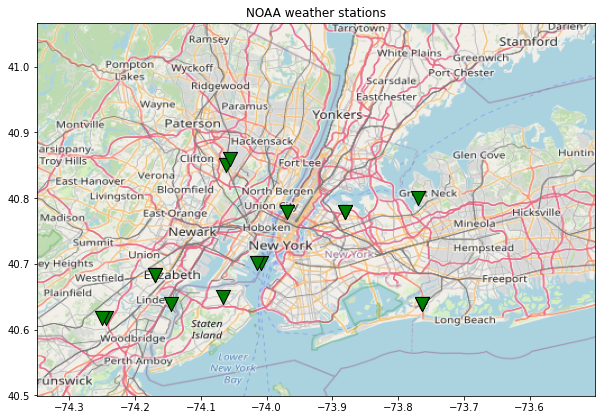

In [17]:
weather_stations = df_noaa.drop_duplicates(subset=['latitude', 'longitude'])

map_bounds_x = (-74.3500, -73.5013)
map_bounds_y = (40.4992, 41.0669)

nyc_map = pyplot.imread('images/nyc-map.png')
fig, ax = pyplot.subplots(figsize=(10, 8))

ax.scatter(weather_stations['longitude'], weather_stations['latitude'], 
               s=200, marker='v', facecolors='green', edgecolors='black')

ax.set_title('NOAA weather stations')
ax.set_xlim(map_bounds_x)
ax.set_ylim(map_bounds_y)
ax.imshow(nyc_map, extent=(*map_bounds_x, *map_bounds_y))

In [18]:
# pivot stations
df_noaa = df_noaa.pivot_table(index=df_noaa.index, columns='station',
                              aggfunc='mean', values='celsius')

<AxesSubplot:title={'center':'7D average region celsius'}, xlabel='utc_time'>

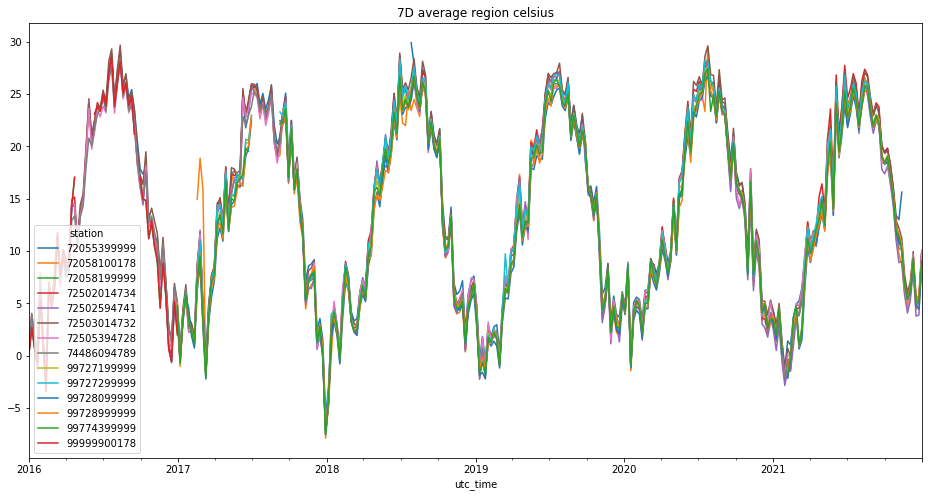

In [19]:
df_noaa.resample('7d').mean().plot(figsize=(16, 8), title='7D average region celsius')

In [20]:
# average across stations
df_noaa_avg = df_noaa.mean(axis='columns').to_frame(name='avg_celsius')

# resample into previous hour (right), take average
df_noaa_avg = df_noaa_avg.resample('1h').mean()

df_noaa_avg = df_noaa_avg.reindex(df_dayahead_lbmp.index, method='nearest')

In [21]:
display(df_noaa_avg)

,avg_celsius
utc_time,
2016-11-01 05:00:00+00:00,5.660000
2016-11-01 06:00:00+00:00,5.312000
2016-11-01 07:00:00+00:00,4.450000
2016-11-01 08:00:00+00:00,4.195000
2016-11-01 09:00:00+00:00,4.350000
...,...
2021-05-01 00:00:00+00:00,12.808750
2021-05-01 01:00:00+00:00,11.276667
2021-05-01 02:00:00+00:00,10.416667


# Discoveries

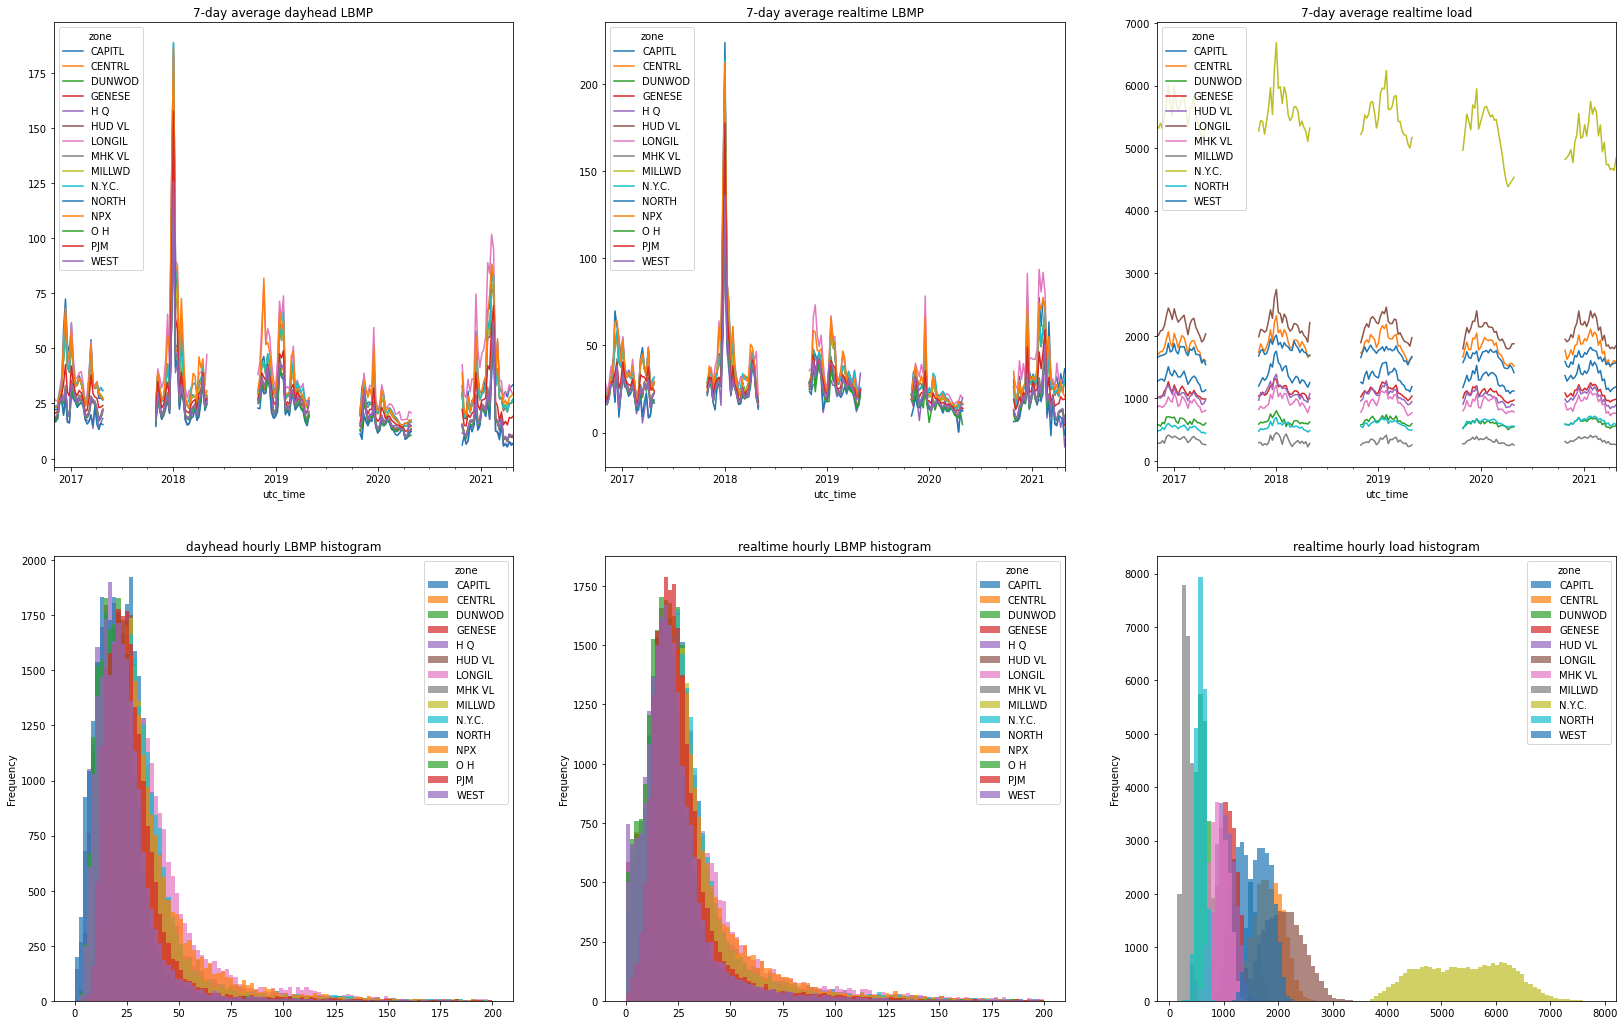

In [22]:
# plot LBMP and load
fig, (ax1, ax2) = pyplot.subplots(2, 3, figsize=(28, 18), squeeze=False)
plots = {
    '7-day average dayhead LBMP': df_dayahead_lbmp.resample('7d').mean(),
    '7-day average realtime LBMP': df_realtime_lbmp.resample('7d').mean(),
    '7-day average realtime load': df_realtime_load.resample('7d').mean(),
}
for index, (plot_name, plot_data) in enumerate(plots.items()):
    plot_data.plot(ax=ax1[index], title=plot_name)

plots = {
    'dayhead hourly LBMP histogram' : (df_dayahead_lbmp, {'range': (0, 200), 'bins': 100, 'alpha': 0.7}),
    'realtime hourly LBMP histogram': (df_realtime_lbmp, {'range': (0, 200), 'bins': 100, 'alpha': 0.7}),
    'realtime hourly load histogram': (df_realtime_load, {'bins': 100, 'alpha': 0.7}),
}
for index, (plot_name, (plot_obj, plot_params)) in enumerate(plots.items()):
    plot_obj.plot.hist(ax=ax2[index], title=plot_name, **plot_params)

<AxesSubplot:title={'center':'histogram of NYC and NORTH dayahead prices'}, ylabel='Frequency'>

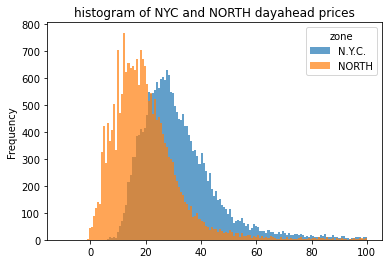

In [23]:
df_dayahead_lbmp[['N.Y.C.', 'NORTH']].plot.hist(bins=150, alpha=0.7, range=[-10, 100],
                                                title='histogram of NYC and NORTH dayahead prices')

In [24]:
display(df_realtime_lbmp[['N.Y.C.', 'NORTH']].describe())

zone,N.Y.C.,NORTH
count,21744.000000,21744.000000
mean,35.096008,21.314184
std,33.366168,32.835840
min,-461.812500,-1432.408333
25%,20.406667,11.043566
50%,27.339583,18.503750
75%,37.831250,26.825000
max,1155.280909,1045.206364


# Discovery (1 of 5) From statistics -- NYC realtime pricing is higher than NORTH

* NYC mean 33.3 USD/MWhr
* NORTH mean 21.3 USD/MWhr

## Possible causes
* Transmission congestion in load center
* Lots of hydro NORTH and near Canada

# Discovery (2 of 5) From statistics -- Negative pricing in NORTH is more extreme than NYC

* NYC low -461.8 USD/MWHr
* NORTH low -1432.4 USD/MWHr

# Possible causes

* Nuclear plants are located upstate
* Transmission congestion around power plants

# Discoveries (3 of 5) -- Weather-related price spike in early 2018

In [25]:
# Convert timezone to EST
df_lo_dayahead_lbmp = df_dayahead_lbmp
df_lo_realtime_lbmp = df_realtime_lbmp
df_lo_realtime_load = df_realtime_load

df_lo_dayahead_lbmp.index = df_lo_dayahead_lbmp.index.tz_convert('America/New_York')
df_lo_realtime_lbmp.index = df_lo_realtime_lbmp.index.tz_convert('America/New_York')
df_lo_realtime_load.index = df_lo_realtime_load.index.tz_convert('America/New_York')

df_lo_dayahead_lbmp.index.name = 'local_time'
df_lo_realtime_lbmp.index.name = 'local_time'
df_lo_realtime_load.index.name = 'local_time'

In [26]:
df_da_top_prices = df_lo_dayahead_lbmp.resample('1d').mean().nlargest(3, columns='N.Y.C.')
df_rt_top_prices = df_lo_realtime_lbmp.resample('1d').mean().nlargest(3, columns='N.Y.C.')

display(df_da_top_prices[['N.Y.C.', 'NORTH']].style.set_caption('dayahead daily average top prices (by NYC)'))
display(df_rt_top_prices[['N.Y.C.', 'NORTH']].style.set_caption('realtime daily average top prices (by NYC)'))

zone,N.Y.C.,NORTH
local_time,,
2018-01-06 00:00:00-05:00,217.922500,168.912500
2018-01-05 00:00:00-05:00,216.479583,176.684167
2018-01-02 00:00:00-05:00,194.886667,96.399167


zone,N.Y.C.,NORTH
local_time,,
2018-01-06 00:00:00-05:00,293.061739,229.753667
2018-01-05 00:00:00-05:00,269.015707,131.180168
2018-01-07 00:00:00-05:00,247.908371,197.267137


![](images/nyc-load-analysis.png)

![](images/nyc-price-analysis.png)

<AxesSubplot:title={'center':'realtime top daily prices (by NYC)'}, xlabel='local_time'>

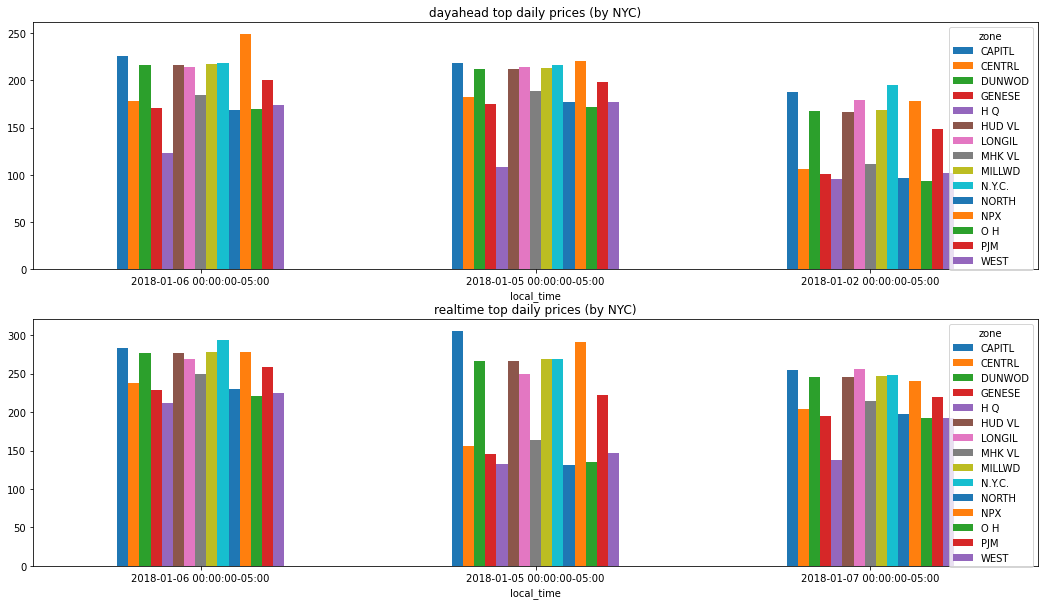

In [27]:
# plot the highest days across the board
fig, ax = pyplot.subplots(2, 1, figsize=(18, 10))
df_da_top_prices.plot.bar(ax=ax[0], title='dayahead top daily prices (by NYC)', rot=0)
df_rt_top_prices.plot.bar(ax=ax[1], title='realtime top daily prices (by NYC)', rot=0)

Text(-80, -10, '2018-01-07 06:00:00-05:00, -14.62°C')

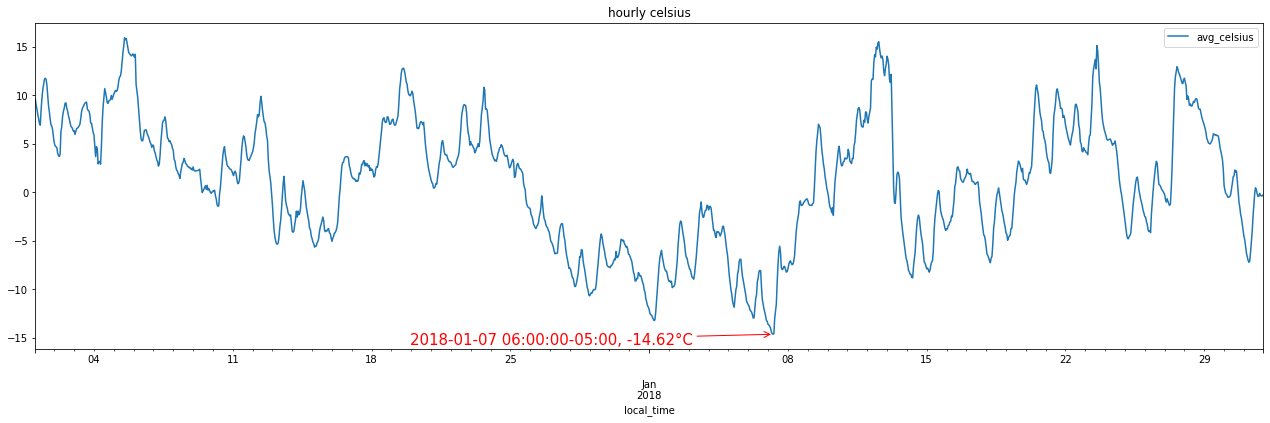

In [28]:
df_lo_noaa = df_noaa_avg
df_lo_noaa.index = df_lo_noaa.index.tz_convert('America/New_York')
df_lo_noaa.index.name = 'local_time'

celsius_period = df_lo_noaa[(df_lo_noaa.index > '2017-12') & (df_lo_noaa.index < '2018-02')]
ax = celsius_period.plot(figsize=(22, 6), title='hourly celsius')
min_celsius_datetime, min_celsius = celsius_period['avg_celsius'].idxmin(), celsius_period['avg_celsius'].min()
ax.annotate('{}, {:-0.2f}°C'.format(min_celsius_datetime, min_celsius), 
            xy=(min_celsius_datetime, min_celsius),
            textcoords='offset points', fontsize=15, c='r',
            ha='right', arrowprops={'arrowstyle': '->', 'color': 'r'},
            xytext=(-80, -10))

![](images/radar.png)

# Possible causes

* When the highest NYC dayahead LBMP prices are observed, the celsius temperatures are all far below zero.
* Other events related to human activity
    * 2018-01-05, -05, -07 are weekends

# Discoveries (4 of 5) -- Correlation of realtime load and celsius with respect to dayahead prices

* Pearson correlation
    * Ignores non-linear correlation

* Spearman rank correlation
    * Any monotonic correlations

* Kendall Tau correlation
    * Insensitive to noise compared to Spearman

In [29]:
# calculates pearson, spearman, and kendall correlation coefficients
# for load and celsius with respect to dayahead prices

corr_methods = (
    'pearson',
    'spearman',
    'kendall',
)

corr_target = df_dayahead_lbmp['N.Y.C.']

corr_sources = {
    'load v.s. dayahead': df_realtime_load['N.Y.C.'],
    'celsius v.s. dayahead': df_lo_noaa['avg_celsius'],
}

corr_result = {
    method: {
        corr_source: corr_target.corr(df_corr_source, method=method)
        for corr_source, df_corr_source in corr_sources.items()
    }
    for method in corr_methods
    
}

df_corr_result = pandas.DataFrame(corr_result)

In [30]:
display(df_corr_result)

,pearson,spearman,kendall
load v.s. dayahead,0.519346,0.656965,0.472260
celsius v.s. dayahead,-0.489185,-0.455465,-0.313912


## Load is highly correlated with dayahead prices

* Positive correlation -- Higher load is associated with higher dayahead prices
* Pearson 0.51  -- strong linear correlation
* Spearman 0.65 -- strong monotonic correlation

## Celsius is highly correlated with dayahead prices

* Negative correlation -- Higher celsius is associated with lower dayahead prices
* Pearson -0.49 -- strong linear correlation
* Spearman -0.46 -- strong monotonic correlation

# Discoveries (5 of 5) Pandemic impact on load profiles and energy prices

## Pandemic time -- Gov. Cuomo executive order effective datetime

* Pre-pandemic `< 2020-03-20 20:00:00 EDT`
* Post-pandemic `>= 2020-03-20 20:00:00 EDT`

![](images/cuomo.png)

In [31]:
# comparing local time
stay_at_home = '2020-03-20 20:00:00'

df_lo_realtime_lbmp_pre = df_lo_realtime_lbmp[df_lo_realtime_lbmp.index < stay_at_home]
df_lo_realtime_lbmp_post = df_lo_realtime_lbmp[df_lo_realtime_lbmp.index >= stay_at_home]

df_lo_realtime_load_pre = df_lo_realtime_load[df_lo_realtime_load.index < stay_at_home]
df_lo_realtime_load_post = df_lo_realtime_load[df_lo_realtime_load.index >= stay_at_home]

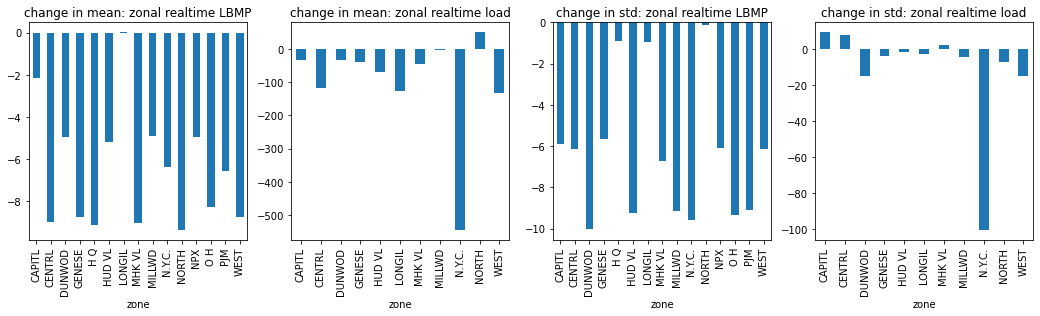

In [32]:
fig, ax = pyplot.subplots(1, 4, figsize=(18, 4), squeeze=True)
ax1 = ax[:2]
ax2 = ax[2:]

plots = {
    'change in mean: zonal realtime LBMP': 
        df_lo_realtime_lbmp_post.mean() - df_lo_realtime_lbmp_pre.mean(),
    
    'change in mean: zonal realtime load':
        df_lo_realtime_load_post.mean() - df_lo_realtime_load_pre.mean(),
}
for index, (plot_name, plot_data) in enumerate(plots.items()):
    plot_data.plot.bar(ax=ax1[index], title=plot_name)


plots = {
     'change in std: zonal realtime LBMP':
        df_lo_realtime_lbmp_post.std() - df_lo_realtime_lbmp_pre.std(),
    
    'change in std: zonal realtime load':
        df_lo_realtime_load_post.std() - df_lo_realtime_load_pre.std(),
}
for index, (plot_name, plot_data) in enumerate(plots.items()):
    plot_data.plot.bar(ax=ax2[index], title=plot_name)

# Looking at means
* Post-pandemic LBMP mean
    * Most zones dropped significantly
    * Long-island stayed the same or increased a little bit
    * NORTH dropped significantly

* Post-pandemic load mean
    * Most zones dropped
    * NYC dropped significantly
    * NORTH increased a little bit
        
# Looking at standard deviation
* Post-pandemic LBMP std
    * NORTH stayed the same or only dropped a little bit

* Post-pandemic load std dropped
    * NYC dropped significantly
    * Capital and central increased

# Goals

## Key factors of energy prices
* datetime, location, load, and temperature
* Presence of a pandemic

## Load Supplied at the zonal and ISO level

In [33]:
display(df_lo_realtime_load.sum(axis='index').to_frame(name='sum'))
print('sum = {}'.format(df_lo_realtime_load.sum(axis='index').sum()))

,sum
zone,
CAPITL,2.876044e+07
CENTRL,3.970937e+07
DUNWOD,1.337323e+07
GENESE,2.357648e+07
HUD VL,2.251724e+07
LONGIL,4.572360e+07
MHK VL,1.985219e+07
MILLWD,6.922903e+06
N.Y.C.,1.163947e+08


sum = 366198464.8245001


## Load variations, peak to valley

In [34]:
display((df_lo_realtime_load.max() - df_lo_realtime_load.min()).to_frame(name='peak-to-valley'))

,peak-to-valley
zone,
CAPITL,1236.5000
CENTRL,1563.8000
DUNWOD,604.4868
GENESE,899.1000
HUD VL,975.1469
LONGIL,2018.6151
MHK VL,914.3000
MILLWD,399.9000
N.Y.C.,4128.4433


## What else learned from price and load data

* The utilities do not sell electircity at wholesale price
    * No negative prices seen in my life

## Products in ISO market

* Electricical energy products
* Generation capacity products
* Transmission products
* Ancillary services
    * Reserves
    * Load following
    * Regulation

## Dayahead prices and realtime prices variations

In [35]:
display(pandas.DataFrame.from_dict({
    'realtime_std': df_realtime_lbmp.std(),
    'dayahead_std': df_dayahead_lbmp.std(),
}))

,realtime_std,dayahead_std
zone,,
CAPITL,35.584889,24.997533
CENTRL,26.990401,17.017171
DUNWOD,32.704585,22.686874
GENESE,25.830506,16.366299
H Q,33.155317,15.634335
HUD VL,31.901232,22.255433
LONGIL,37.633107,27.049494
MHK VL,28.688808,17.744544
MILLWD,32.007142,22.565917


# Conclusion

* Make sure data is imported correctly
    * Garbage in garbage out
    * Timezones
    * Missing values
    * Timestamp alignment

* Temperature is important
    * Load forecast
    * Pricing forecast
    * Extreme weather event readiness
    
* Electricity usage and pricing is highly correlated with human activity
    * Time of day
    * Day of week
    * Government policy -- pandemic